In [1]:
import io
import base64
import pandas as pd
import numpy as np
from helper_fcts import preprocess, get_poi_mas, rps
from keras import backend as K
from sklearn.preprocessing import scale, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, SVC
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from IPython.display import SVG, HTML
from operator import itemgetter
from scipy.stats import poisson
from mpl_toolkits.mplot3d import Axes3D
from prediction import get_predictions

from main import modelling

C:\Users\Konny\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.concat([modelling(pd.read_csv("data/E" + str(i) + ".csv"), 20) for i in range(8,19)])

C:\Users\Konny\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:493: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0


In [4]:
year = 18
league = "eng"

### 4.2 Random Forest

In [1935]:
columns_mit_fe  = ['FTR', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_avgC', 'A_avgC', 'H_avgC_c', 'A_avgC_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2.loc[:,columns_mit_fe]
data.dropna(inplace=True)
X_train = data[data["season"]<year].iloc[:,1:]
X_test = data[data["season"]==year].iloc[:,1:]
y_train = data[data["season"]<year].loc[:,"FTR"]
y_test = data[data["season"]==year].loc[:,"FTR"]

In [1936]:
clf = RandomForestClassifier(n_estimators=50,max_depth=4)

- training data: seasons 2008 - 2017
- test data: season 2018

In [1937]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1938]:
rdf_preds = clf.predict_proba(X_test)

In [1939]:
test_df = data2.iloc[data[data["season"] == year].index]
test_df.reset_index(drop=True, inplace=True)
test_df[columns_mit_fe].dropna(inplace=True)
test_df2 = pd.concat([test_df, pd.DataFrame(rdf_preds, columns = ["Clf_A", "Clf_D", "Clf_H"])], axis=1)
test_df2["rps_Clf"] = rps(test_df2["Clf_H"], test_df2["Clf_D"], test_df2["Clf_A"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [1940]:
print("--------------------------------------------")
print(f"Bookmaker RPS: {np.round(test_df2['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"Random Forest RPS: {np.round(test_df2['rps_Clf'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Bookmaker RPS: 0.2008
--------------------------------------------
Random Forest RPS: 0.203
--------------------------------------------


##### Feature Importance (by random forest)

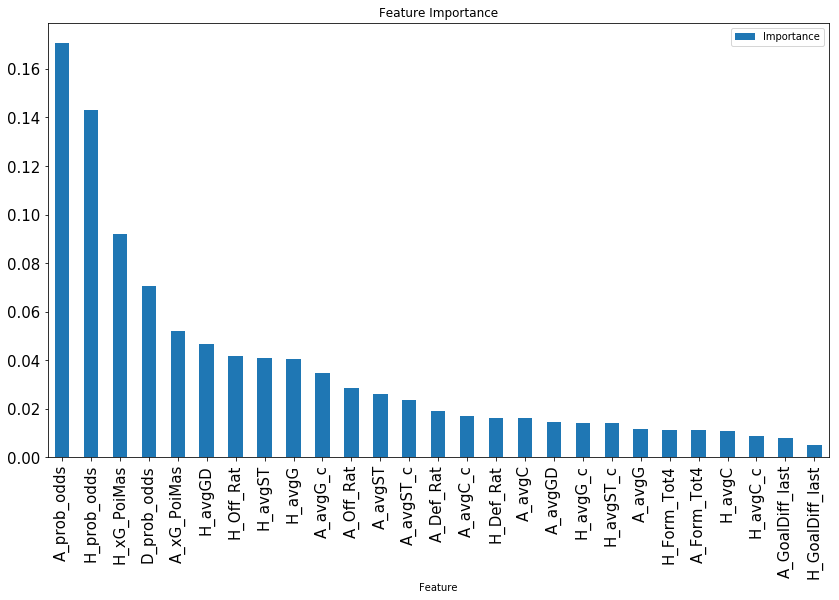

In [1941]:
%matplotlib inline
importance = sorted(zip(X_train.columns, clf.feature_importances_), key=itemgetter(1), reverse=True)
fe_imp = pd.DataFrame(importance, columns=["Feature", "Importance"]).set_index("Feature")
fe_imp.drop("season", inplace=True)
fe_imp.plot(figsize=(14, 8),kind='bar', title="Feature Importance", fontsize=15)

- bookie´s odds seem to be a good measure for team strength
- momentum seems unimportant

### 4.3 XGBoost

In [1942]:
model = XGBClassifier(n_estimators=50, max_depth=4)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [1943]:
xgb_preds = model.predict_proba(X_test)

In [1944]:
test_df = data2.iloc[data[data["season"] == year].index]
test_df.reset_index(drop=True, inplace=True)
test_df[columns_mit_fe].dropna(inplace=True)
test_df2 = pd.concat([test_df, pd.DataFrame(xgb_preds, columns = ["Clf_A", "Clf_D", "Clf_H"])], axis=1)
test_df2["rps_Clf"] = rps(test_df2["Clf_H"], test_df2["Clf_D"], test_df2["Clf_A"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [1945]:
print("--------------------------------------------")
print(f"Bookmaker RPS: {np.round(test_df2['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"XGBoost RPS: {np.round(test_df2['rps_Clf'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Bookmaker RPS: 0.2008
--------------------------------------------
XGBoost RPS: 0.2105
--------------------------------------------


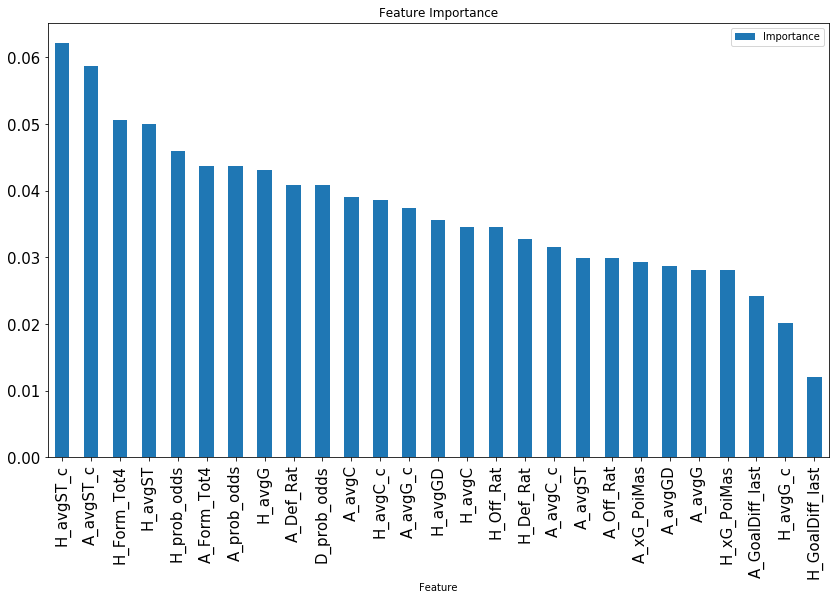

In [1946]:
importance = sorted(zip(X_train.columns, model.feature_importances_), key=itemgetter(1), reverse=True)
fe_imp = pd.DataFrame(importance, columns=["Feature", "Importance"]).set_index("Feature")
fe_imp.drop("season", inplace=True)
fe_imp.plot(figsize=(14, 8),kind='bar', title="Feature Importance", fontsize=15)

- goal difference of the last match is again the most unimportant feature
- the more sophisticated momentum measure (Form_Tot4) is now one of the most important features!

### 4.4 Artificial Neural Network

In [12]:
columns_mit_fe  = ['Home', 'Draw', 'Away', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_avgC', 'A_avgC', 'H_avgC_c', 'A_avgC_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]

def get_season(df, season):
    X_train = df[df["season"] < season].iloc[:,4:]
    X_test = df[df["season"] == season].iloc[:,4:]
    y_train = df[df["season"] < season].iloc[:,:3]
    y_test = df[df["season"] == season].iloc[:,:3]
    return X_train, X_test, y_train, y_test

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2[columns_mit_fe]
data.dropna(inplace=True)

X_train, X_test, y_train, y_test = get_season(data, year)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
def loss_rps(y_true, y_pred):
    prob_h = y_pred[:, 0]
    prob_d = y_pred[:, 1]
    home = y_true[:, 0]
    draw = y_true[:, 1]

    step1 = prob_h - home
    step2 = prob_d - draw
    summe = step1 + step2
    return (step1 ** 2 + summe ** 2) / 2

In [25]:
K.clear_session()

model = Sequential()
model.add(Dense(256, kernel_initializer="he_normal", input_shape=(27,)))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(128, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(3, kernel_initializer="he_normal"))
model.add(Activation('softmax'))

model.compile(loss=loss_rps, optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs=75, verbose=True, validation_data=(X_test, y_test))

Train on 2798 samples, validate on 280 samples
Epoch 1/75
2798/2798 [==============================] - 1s 257us/step - loss: 0.2813 - acc: 0.4339 - val_loss: 0.2366 - val_acc: 0.5107
Epoch 2/75
2798/2798 [==============================] - 0s 115us/step - loss: 0.2624 - acc: 0.4557 - val_loss: 0.2358 - val_acc: 0.5107
Epoch 3/75
2798/2798 [==============================] - 0s 98us/step - loss: 0.2542 - acc: 0.4671 - val_loss: 0.2219 - val_acc: 0.5321
Epoch 4/75
2798/2798 [==============================] - 0s 110us/step - loss: 0.2514 - acc: 0.4435 - val_loss: 0.2123 - val_acc: 0.5500
Epoch 5/75
2798/2798 [==============================] - 0s 134us/step - loss: 0.2343 - acc: 0.4703 - val_loss: 0.2053 - val_acc: 0.5357
Epoch 6/75
2798/2798 [==============================] - 0s 135us/step - loss: 0.2293 - acc: 0.4707 - val_loss: 0.1992 - val_acc: 0.5429
Epoch 7/75
2798/2798 [==============================] - 0s 126us/step - loss: 0.2163 - acc: 0.4843 - val_loss: 0.1941 - val_acc: 0.5250
Ep

In [27]:
print("--------------------------------------------")
print(f"Train Dataset:\n RPS: {np.round(model.evaluate(X_train, y_train, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_train, y_train, verbose=0)[1],4)}")
print("--------------------------------------------")
print(f"Test Dataset:\n RPS: {np.round(model.evaluate(X_test, y_test, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_test, y_test, verbose=0)[1],4)}")
print("--------------------------------------------")

--------------------------------------------
Train Dataset:
 RPS: 0.1708, Accuracy: 0.5865
--------------------------------------------
Test Dataset:
 RPS: 0.1813, Accuracy: 0.5536
--------------------------------------------


In [28]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

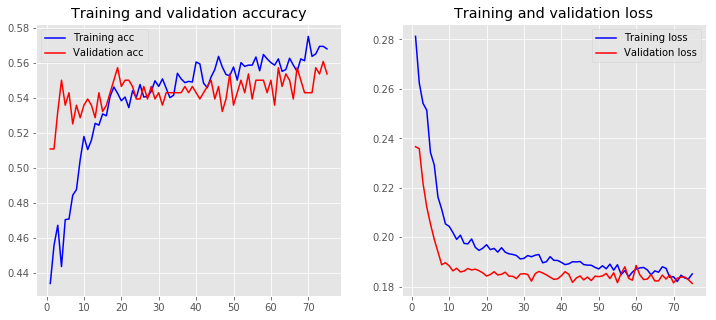

In [29]:
plot_history(history)

In [1952]:
ann_preds = model.predict(X_test)

In [1953]:
test_df = data2.iloc[data[data["season"] == year].index]
test_df.reset_index(drop=True, inplace=True)
rdf_pred = pd.DataFrame(rdf_preds, columns = ["A_pred_Rdf", "D_pred_Rdf", "H_pred_Rdf"])
xgb_pred = pd.DataFrame(xgb_preds, columns = ["A_pred_Xgb", "D_pred_Xgb", "H_pred_Xgb"])
ann_pred = pd.DataFrame(ann_preds, columns = ["H_pred_Ann", "D_pred_Ann", "A_pred_Ann"])
test_df2 = pd.concat([test_df, rdf_pred, xgb_pred, ann_pred], axis=1)
test_df2["rps_Rdf"] = rps(test_df2["H_pred_Rdf"], test_df2["D_pred_Rdf"], test_df2["A_pred_Rdf"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])
test_df2["rps_Xgb"] = rps(test_df2["H_pred_Xgb"], test_df2["D_pred_Xgb"], test_df2["A_pred_Xgb"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])
test_df2["rps_ANN"] = rps(test_df2["H_pred_Ann"], test_df2["D_pred_Ann"], test_df2["A_pred_Ann"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

In [1954]:
print("--------------------------------------------")
print("METHOD:           RPS:")
print("--------------------------------------------")
print(f"Bookmaker:          {np.round(test_df2['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"Poisson:            {np.round(test_df2['rps_Poi_mix'].mean(), 4)}")
print("--------------------------------------------")
print(f"Random Forest:      {np.round(test_df2['rps_Rdf'].mean(), 4)}")
print("--------------------------------------------")
print(f"XGBoost:            {np.round(test_df2['rps_Xgb'].mean(), 4)}")
print("--------------------------------------------")
print(f"Neural Network:     {np.round(test_df2['rps_ANN'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
METHOD:           RPS:
--------------------------------------------
Bookmaker:          0.2008
--------------------------------------------
Poisson:            0.2082
--------------------------------------------
Random Forest:      0.203
--------------------------------------------
XGBoost:            0.2105
--------------------------------------------
Neural Network:     0.2076
--------------------------------------------


## 5. Betting Strategy

place bet, if the average of the predictions suggest a higher winning probability than the odds by a certain margin

In [1955]:
test_df2["H_pred_avg"] = (test_df2["H_pred_Rdf"] + test_df2["H_pred_Xgb"] + test_df2["H_pred_Ann"]) / 3
test_df2["D_pred_avg"] = (test_df2["D_pred_Rdf"] + test_df2["D_pred_Xgb"] + test_df2["D_pred_Ann"]) / 3
test_df2["A_pred_avg"] = (test_df2["A_pred_Rdf"] + test_df2["A_pred_Xgb"] + test_df2["A_pred_Ann"]) / 3

In [1956]:
test_df2[["HomeTeam", "AwayTeam", "H_prob_odds", "H_pred_Rdf", "H_pred_Xgb", "H_pred_Ann", "H_pred_avg"]].tail()

,HomeTeam,AwayTeam,H_prob_odds,H_pred_Rdf,H_pred_Xgb,H_pred_Ann,H_pred_avg
211,Hoffenheim,Schalke 04,0.281943,0.335451,0.323506,0.209593,0.289516
212,Leverkusen,Ingolstadt,0.580361,0.553211,0.513528,0.623833,0.563524
213,Mainz,Hertha,0.480583,0.479283,0.463710,0.460415,0.467803
214,Werder Bremen,Ein Frankfurt,0.502774,0.460966,0.612363,0.469711,0.514346
215,Wolfsburg,Stuttgart,0.468785,0.488874,0.623869,0.508298,0.540347


In [1957]:
test_df2["rps_avg"] = rps(test_df2["H_pred_avg"], test_df2["D_pred_avg"], test_df2["A_pred_avg"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

In [1958]:
print("--------------------------------------------")
print(f"Average prediction RPS: {np.round(test_df2['rps_avg'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Average prediction RPS: 0.2049
--------------------------------------------


In [1959]:
value = 0.1

a = test_df2[test_df2["H_pred_Ann"] / test_df2["H_prob_odds"] -1 > value]["H_PL"].describe()
print(f"\nBets on Home Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(a['count'])}\nAvg. Yield: {np.round(a['mean'] * 100, 2)}%\nMax winning odds: {np.round(a['max'] + 1, 2)}")
print("======================================================================")
b = test_df2[test_df2["H_pred_Ann"] / test_df2["H_prob_odds"] -1 > value]["H_Ahc_PL"].describe()
print(f"\nBets on Home Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(b['count'])}\nAvg. Yield: {np.round(b['mean'] * 100, 2)}%\nMax winning odds: {np.round(b['max'] + 1, 2)}")


Bets on Home Teams in 1X2 market:

Nr of Matches: 216
Nr of Bets: 44
Avg. Yield: -5.68%
Max winning odds: 10.24

Bets on Home Teams in asian handicap market:

Nr of Matches: 216
Nr of Bets: 44
Avg. Yield: -1.35%
Max winning odds: 2.14


In [1960]:
c = test_df2[test_df2["A_pred_Ann"] / test_df2["A_prob_odds"] -1 > value]["A_PL"].describe()
print(f"\nBets on Away Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(c['count'])}\nAvg. Yield: {np.round(c['mean'] * 100, 2)}%\nMax winning odds: {np.round(c['max'] + 1, 2)}")
print("======================================================================")
d = test_df2[test_df2["A_pred_Ann"] / test_df2["A_prob_odds"] -1 > value]["A_Ahc_PL"].describe()
print(f"\nBets on Away Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(d['count'])}\nAvg. Yield: {np.round(d['mean'] * 100, 2)}%\nMax winning odds: {np.round(d['max'] + 1, 2)}")


Bets on Away Teams in 1X2 market:

Nr of Matches: 216
Nr of Bets: 66
Avg. Yield: -18.44%
Max winning odds: 4.08

Bets on Away Teams in asian handicap market:

Nr of Matches: 216
Nr of Bets: 66
Avg. Yield: -1.82%
Max winning odds: 2.07


##### Profit/Loss on Home Bets:

In [1961]:
value = 0.1

a = test_df2[test_df2["H_pred_avg"] / test_df2["H_prob_odds"] -1 > value]["H_PL"].describe()
print(f"\nBets on Home Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(a['count'])}\nAvg. Yield: {np.round(a['mean'] * 100, 2)}%\nMax winning odds: {np.round(a['max'] + 1, 2)}")
print("======================================================================")
b = test_df2[test_df2["H_pred_avg"] / test_df2["H_prob_odds"] -1 > value]["H_Ahc_PL"].describe()
print(f"\nBets on Home Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(b['count'])}\nAvg. Yield: {np.round(b['mean'] * 100, 2)}%\nMax winning odds: {np.round(b['max'] + 1, 2)}")


Bets on Home Teams in 1X2 market:

Nr of Matches: 216
Nr of Bets: 49
Avg. Yield: 1.92%
Max winning odds: 10.24

Bets on Home Teams in asian handicap market:

Nr of Matches: 216
Nr of Bets: 49
Avg. Yield: 3.19%
Max winning odds: 2.18


##### Profit/Loss on Away Bets:

In [1962]:
c = test_df2[test_df2["A_pred_avg"] / test_df2["A_prob_odds"] -1 > value]["A_PL"].describe()
print(f"\nBets on Away Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(c['count'])}\nAvg. Yield: {np.round(c['mean'] * 100, 2)}%\nMax winning odds: {np.round(c['max'] + 1, 2)}")
print("======================================================================")
d = test_df2[test_df2["A_pred_avg"] / test_df2["A_prob_odds"] -1 > value]["A_Ahc_PL"].describe()
print(f"\nBets on Away Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(d['count'])}\nAvg. Yield: {np.round(d['mean'] * 100, 2)}%\nMax winning odds: {np.round(d['max'] + 1, 2)}")


Bets on Away Teams in 1X2 market:

Nr of Matches: 216
Nr of Bets: 57
Avg. Yield: -1.32%
Max winning odds: 24.43

Bets on Away Teams in asian handicap market:

Nr of Matches: 216
Nr of Bets: 57
Avg. Yield: 1.67%
Max winning odds: 2.07


## 6. Predicting Goal Difference instead of Classification

#### XGB Regressor

In [1963]:
columns_mit_fe  = ['FTHG', 'FTAG', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_avgC', 'A_avgC', 'H_avgC_c', 'A_avgC_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]
def get_season(df, season):
    X_train = df[df["season"] < season].iloc[:,2:]
    X_test = df[df["season"] == season].iloc[:,2:]
    y_train_hg = df[df["season"] < season].iloc[:,0]
    y_test_hg = df[df["season"] == season].iloc[:,0]
    y_train_ag = df[df["season"] < season].iloc[:,1]
    y_test_ag = df[df["season"] == season].iloc[:,1]
    return X_train, X_test, y_train_hg, y_test_hg, y_train_ag, y_test_ag

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2[columns_mit_fe]
data.dropna(inplace=True)

X_train, X_test, y_train_hg, y_test_hg, y_train_ag, y_test_ag = get_season(data, year)

del X_train["season"]
del X_test["season"]

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1964]:
y_train_hg = y_train_hg.reshape((-1,1))
scaler_hg = StandardScaler()
scaler_hg.fit(y_train_hg)
y_train_hg = scaler_hg.transform(y_train_hg)

y_train_ag = y_train_ag.reshape((-1,1))
scaler_ag = StandardScaler()
scaler_ag.fit(y_train_ag)
y_train_ag = scaler_ag.transform(y_train_ag)

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
C:\Users\Konny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [1965]:
#home
model_h = XGBRegressor(n_estimators=50, max_depth=4)
model_h.fit(X_train, y_train_hg)
xgb_home = model_h.predict(X_test)

#away
model_a = XGBRegressor(n_estimators=50, max_depth=4)
model_a.fit(X_train, y_train_ag)
xgb_away = model_a.predict(X_test)

In [1966]:
xgb_home = scaler_hg.inverse_transform(xgb_home)
xgb_away = scaler_ag.inverse_transform(xgb_away)

In [1967]:
test_df = data2.iloc[data[data["season"] == year].index]
test_df.reset_index(drop=True, inplace=True)
test_df["H_xgb_xG"] = xgb_home
test_df["A_xgb_xG"] = xgb_away
test_df["XGB_hc"] = test_df["A_xgb_xG"] - test_df["H_xgb_xG"]
test_df["Hc_Diff"] = test_df["BbAHh"] - test_df["XGB_hc"]

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [1968]:
test_df[test_df["Hc_Diff"] > 0.3].H_Ahc_PL.describe()

count    44.000000
mean      0.125114
std       0.872505
min      -1.000000
25%      -1.000000
50%       0.460000
75%       0.915000
max       1.040000
Name: H_Ahc_PL, dtype: float64

In [1969]:
test_df[test_df["Hc_Diff"] < -0.3].A_Ahc_PL.describe()

count    41.000000
mean      0.234756
std       0.837116
min      -1.000000
25%      -1.000000
50%       0.790000
75%       0.890000
max       1.070000
Name: A_Ahc_PL, dtype: float64

### SVR

In [1970]:
columns_mit_fe  = ['FTHG', 'FTAG', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_avgC', 'A_avgC', 'H_avgC_c', 'A_avgC_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]


def get_season(df, season):
    X_train = df[df["season"] < season].iloc[:,2:]
    X_test = df[df["season"] == season].iloc[:,2:]
    y_train_hg = df[df["season"] < season].iloc[:,0]
    y_test_hg = df[df["season"] == season].iloc[:,0]
    y_train_ag = df[df["season"] < season].iloc[:,1]
    y_test_ag = df[df["season"] == season].iloc[:,1]
    return X_train, X_test, y_train_hg, y_test_hg, y_train_ag, y_test_ag

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2[columns_mit_fe]
data.dropna(inplace=True)

X_train, X_test, y_train_hg, y_test_hg, y_train_ag, y_test_ag = get_season(data, year)

del X_train["season"]
del X_test["season"]

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1971]:
y_train_hg = y_train_hg.reshape((-1,1))
scaler_hg = StandardScaler()
scaler_hg.fit(y_train_hg)
y_train_hg = scaler_hg.transform(y_train_hg)

y_train_ag = y_train_ag.reshape((-1,1))
scaler_ag = StandardScaler()
scaler_ag.fit(y_train_ag)
y_train_ag = scaler_ag.transform(y_train_ag)

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
C:\Users\Konny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [1972]:
#home
model_h = SVR(C=0.01)
model_h.fit(X_train, y_train_hg)
svr_home = model_h.predict(X_test)

#away
model_a = SVR(C=0.01)
model_a.fit(X_train, y_train_ag)
svr_away = model_a.predict(X_test)

C:\Users\Konny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1973]:
svr_home = scaler_hg.inverse_transform(svr_home)
svr_away = scaler_ag.inverse_transform(svr_away)

In [1974]:
test_df = data2.iloc[data[data["season"] == year].index]
test_df.reset_index(drop=True, inplace=True)
test_df["H_svr_xG"] = svr_home
test_df["A_svr_xG"] = svr_away
test_df["SVR_hc"] = test_df["A_svr_xG"] - test_df["H_svr_xG"]
test_df["Hc_Diff"] = test_df["BbAHh"] - test_df["SVR_hc"]

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [1975]:
test_df[test_df["Hc_Diff"] > 0.5].H_Ahc_PL.describe()

count    31.000000
mean      0.093548
std       0.908176
min      -1.000000
25%      -1.000000
50%       0.660000
75%       0.850000
max       1.180000
Name: H_Ahc_PL, dtype: float64

In [1976]:
test_df[test_df["Hc_Diff"] < -0.5].A_Ahc_PL.describe()

count    23.000000
mean      0.126522
std       0.925599
min      -1.000000
25%      -1.000000
50%       0.740000
75%       1.000000
max       1.070000
Name: A_Ahc_PL, dtype: float64

### Artificial Neural Network

In [30]:
columns_mit_fe  = ['FTHG', 'FTAG', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_avgC', 'A_avgC', 'H_avgC_c', 'A_avgC_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]

def get_season(df, season):
    X_train = df[df["season"] < season].iloc[:,2:]
    X_test = df[df["season"] == season].iloc[:,2:]
    y_train = df[df["season"] < season].iloc[:,:2]
    y_test = df[df["season"] == season].iloc[:,:2]
    return X_train, X_test, y_train, y_test


data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2[columns_mit_fe]
data.dropna(inplace=True)

X_train, X_test, y_train, y_test = get_season(data, year)

del X_train["season"]
del X_test["season"]

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
scaler_goals = StandardScaler()
scaler_goals.fit(y_train)

y_train = scaler_goals.transform(y_train)
y_test = scaler_goals.transform(y_test)

In [51]:
K.clear_session()

model = Sequential()
model.add(Dense(128, kernel_initializer="he_normal", input_shape=(27,)))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(2, kernel_initializer="he_normal"))
model.add(Activation('linear'))

model.compile(loss="logcosh", optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 2798 samples, validate on 280 samples
Epoch 1/100
2798/2798 [==============================] - 0s 166us/step - loss: 0.8638 - acc: 0.5286 - val_loss: 0.3312 - val_acc: 0.6429
Epoch 2/100
2798/2798 [==============================] - 0s 72us/step - loss: 0.5725 - acc: 0.5461 - val_loss: 0.3307 - val_acc: 0.6250
Epoch 3/100
2798/2798 [==============================] - 0s 88us/step - loss: 0.4764 - acc: 0.5522 - val_loss: 0.3289 - val_acc: 0.6286
Epoch 4/100
2798/2798 [==============================] - 0s 89us/step - loss: 0.4186 - acc: 0.5679 - val_loss: 0.3260 - val_acc: 0.6429
Epoch 5/100
2798/2798 [==============================] - 0s 72us/step - loss: 0.3926 - acc: 0.5793 - val_loss: 0.3281 - val_acc: 0.6357
Epoch 6/100
2798/2798 [==============================] - 0s 72us/step - loss: 0.3732 - acc: 0.6019 - val_loss: 0.3256 - val_acc: 0.6321
Epoch 7/100
2798/2798 [==============================] - 0s 67us/step - loss: 0.3653 - acc: 0.6022 - val_loss: 0.3255 - val_acc: 0.6393


In [49]:
print(f"Train Dataset:\n RPS: {np.round(model.evaluate(X_train, y_train, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_train, y_train, verbose=0)[1],4)}")
print("--------------------------------------------")
print(f"Test Dataset:\n RPS: {np.round(model.evaluate(X_test, y_test, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_test, y_test, verbose=0)[1],4)}")
print("--------------------------------------------")

Train Dataset:
 RPS: 0.2659, Accuracy: 0.7216
--------------------------------------------
Test Dataset:
 RPS: 0.3213, Accuracy: 0.6786
--------------------------------------------


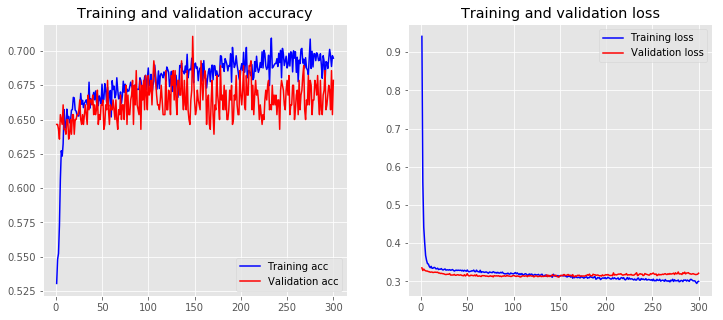

In [50]:
plot_history(history)

In [1982]:
y_pred = model.predict(X_test)

y_pred = scaler_goals.inverse_transform(y_pred)

test_df = data2.iloc[data[data["season"] == year].index]
test_df.reset_index(drop=True, inplace=True)

test_df["H_xgb_xG"] = xgb_home
test_df["A_xgb_xG"] = xgb_away
test_df["XGB_hc"] = test_df["A_xgb_xG"] - test_df["H_xgb_xG"]
test_df["Hc_Diff_xgb"] = test_df["BbAHh"] - test_df["XGB_hc"]

test_df["H_svr_xG"] = svr_home
test_df["A_svr_xG"] = svr_away
test_df["SVR_hc"] = test_df["A_svr_xG"] - test_df["H_svr_xG"]
test_df["Hc_Diff_svr"] = test_df["BbAHh"] - test_df["SVR_hc"]

ann_pred2 = pd.DataFrame(y_pred, columns = ["H_ann_xG", "A_ann_xG"])
test_df2 = pd.concat([test_df, ann_pred2], axis=1)
test_df2["ANN_hc"] = test_df2["A_ann_xG"] - test_df2["H_ann_xG"]
test_df2["Hc_Diff_ann"] = test_df2["BbAHh"] - test_df2["ANN_hc"]

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

In [1983]:
difference = 0.2

test_df2[(test_df2["Hc_Diff_ann"] > difference) & (test_df2["BbAvAHH"] > 1.8)].H_Ahc_PL.describe()

count    60.000000
mean      0.070167
std       0.865251
min      -1.000000
25%      -1.000000
50%       0.230000
75%       0.870000
max       1.180000
Name: H_Ahc_PL, dtype: float64

In [1984]:
test_df2[(test_df2["Hc_Diff_ann"] < -difference) & (test_df2["BbAvAHA"] > 1.8)].A_Ahc_PL.describe()

count    45.000000
mean      0.220889
std       0.858213
min      -1.000000
25%      -1.000000
50%       0.810000
75%       0.950000
max       1.070000
Name: A_Ahc_PL, dtype: float64

In [1985]:
test_df2["Hc_Diff_avg"] = (test_df2["Hc_Diff_ann"] + test_df2["Hc_Diff_xgb"] + test_df2["Hc_Diff_svr"]) / 3

In [1986]:
test_df2[["HomeTeam", "AwayTeam", "Hc_Diff_ann", "Hc_Diff_xgb", "Hc_Diff_svr", "Hc_Diff_avg"]].tail()

,HomeTeam,AwayTeam,Hc_Diff_ann,Hc_Diff_xgb,Hc_Diff_svr,Hc_Diff_avg
211,Hoffenheim,Schalke 04,-0.466325,-0.118009,0.221919,-0.120805
212,Leverkusen,Ingolstadt,-0.003091,-0.149079,-0.354454,-0.168875
213,Mainz,Hertha,-0.046845,0.178083,-0.100892,0.010115
214,Werder Bremen,Ein Frankfurt,0.198309,0.391057,-0.069176,0.173397
215,Wolfsburg,Stuttgart,0.551735,0.532011,0.205043,0.429596


In [1987]:
difference = 0.15

test_df2[(test_df2["Hc_Diff_avg"] > difference) & (test_df2["BbAvAHH"] > 1.8)].H_Ahc_PL.describe()

count    57.000000
mean      0.178158
std       0.869181
min      -1.000000
25%      -1.000000
50%       0.810000
75%       0.890000
max       1.180000
Name: H_Ahc_PL, dtype: float64

In [1988]:
test_df2[(test_df2["Hc_Diff_avg"] < -difference) & (test_df2["BbAvAHA"] > 1.8)].A_Ahc_PL.describe()

count    39.000000
mean      0.229744
std       0.857784
min      -1.000000
25%      -1.000000
50%       0.820000
75%       0.930000
max       1.070000
Name: A_Ahc_PL, dtype: float64

In [1989]:
test_df2["xg_cum"] = (test_df2["H_ann_xG"] + test_df2["A_ann_xG"] + test_df2['H_svr_xG'] + test_df2['A_svr_xG'] + test_df2['H_xgb_xG'] + test_df2['A_xgb_xG']) / 3

In [1990]:
test_df2["xg_ann_cum"] = test_df2["H_ann_xG"] + test_df2["A_ann_xG"]

In [1991]:
test_df2[(test_df2["xg_cum"]>2.5) & (test_df2["Over_prob_odds"] < 0.5)].Over_PL.describe()

count    26.000000
mean     -0.086923
std       1.006848
min      -1.000000
25%      -1.000000
50%      -1.000000
75%       0.957500
max       1.170000
Name: Over_PL, dtype: float64

In [1992]:
test_df2[(test_df2["xg_cum"]<2.5) & (test_df2["Under_prob_odds"] < 0.5)].Under_PL.describe()

count    24.000000
mean      0.101250
std       1.152111
min      -1.000000
25%      -1.000000
50%      -0.045000
75%       1.062500
max       2.230000
Name: Under_PL, dtype: float64

In [1993]:
test_df2[(test_df2["xg_cum"]<2.5) & (test_df2["Under_prob_odds"] < 0.5)][["Date", "HomeTeam", "AwayTeam", "BbAv>2.5", "BbAv<2.5"]].tail(10)

,Date,HomeTeam,AwayTeam,BbAv>2.5,BbAv<2.5
163,09/04/16,Ein Frankfurt,Hoffenheim,1.74,2.07
168,09/04/16,Wolfsburg,Mainz,1.78,2.02
180,22/04/16,Hamburg,Werder Bremen,1.72,2.11
186,23/04/16,Wolfsburg,Augsburg,1.64,2.23
189,29/04/16,Augsburg,FC Koln,1.87,1.91
196,30/04/16,Mainz,Hamburg,1.76,2.04
199,07/05/16,FC Koln,Werder Bremen,1.50,2.52
202,07/05/16,Hertha,Darmstadt,1.84,1.95
207,14/05/16,Augsburg,Hamburg,1.65,2.20
213,14/05/16,Mainz,Hertha,1.74,2.06


### Combination between Classification and Regression

In [1994]:
test_df3 = pd.concat([test_df2, rdf_pred, xgb_pred, ann_pred], axis=1)
test_df3["rps_Rdf"] = rps(test_df3["H_pred_Rdf"], test_df3["D_pred_Rdf"], test_df3["A_pred_Rdf"], test_df3["Home"], test_df3["Draw"], test_df3["Away"])
test_df3["rps_Xgb"] = rps(test_df3["H_pred_Xgb"], test_df3["D_pred_Xgb"], test_df3["A_pred_Xgb"], test_df3["Home"], test_df3["Draw"], test_df3["Away"])
test_df3["rps_ANN"] = rps(test_df3["H_pred_Ann"], test_df3["D_pred_Ann"], test_df3["A_pred_Ann"], test_df3["Home"], test_df3["Draw"], test_df3["Away"])

test_df3["H_pred_avg"] = (test_df3["H_pred_Rdf"] + test_df3["H_pred_Xgb"] + test_df3["H_pred_Ann"]) / 3
test_df3["D_pred_avg"] = (test_df3["D_pred_Rdf"] + test_df3["D_pred_Xgb"] + test_df3["D_pred_Ann"]) / 3
test_df3["A_pred_avg"] = (test_df3["A_pred_Rdf"] + test_df3["A_pred_Xgb"] + test_df3["A_pred_Ann"]) / 3
test_df3["rps_avg"] = rps(test_df3["H_pred_avg"], test_df3["D_pred_avg"], test_df3["A_pred_avg"], test_df3["Home"], test_df3["Draw"], test_df3["Away"])

In [1995]:
difference = 0.05
value = 0.05

test_df3[(test_df3["Hc_Diff_avg"] > difference) & (test_df3["H_pred_avg"] / test_df3["H_prob_odds"] - 1 > value)].H_Ahc_PL.describe()

count    52.000000
mean      0.044712
std       0.896159
min      -1.000000
25%      -1.000000
50%       0.412500
75%       0.890000
max       1.180000
Name: H_Ahc_PL, dtype: float64

In [1996]:
test_df3[(test_df3["Hc_Diff_avg"] < -difference) & (test_df3["A_pred_avg"] / test_df3["A_prob_odds"] - 1 > value)].A_Ahc_PL.describe()

count    46.000000
mean      0.055761
std       0.900320
min      -1.000000
25%      -1.000000
50%       0.397500
75%       0.915000
max       1.070000
Name: A_Ahc_PL, dtype: float64

## 7. Still To Do:
- Get hands on more detailed data
- LineUps
- Market Value
- Twitter Sentiment Analysis of the matches
- GUI

In [1997]:
test_df3.to_pickle(f"{league}{year}_all.pkl")

In [8]:
get_predictions("eng3")

C:\Users\Konny\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:493: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0


,HomeTeam,AwayTeam,H_prob_odds,D_prob_odds,A_prob_odds,BbAHh,H_pred_avg,D_pred_avg,A_pred_avg,Hc_avg,...,H_pred_Ann,D_pred_Rdf,D_pred_Xgb,D_pred_Ann,A_pred_Rdf,A_pred_Xgb,A_pred_Ann,XGB_hc,SVR_hc,ANN_hc
0,Accrington,Portsmouth,0.306520,0.291336,0.402144,0.25,0.291676,0.256982,0.451341,0.257023,...,0.219813,0.246727,0.270694,0.253526,0.453755,0.373608,0.526661,0.444617,0.055945,0.270506
1,AFC Wimbledon,Luton,0.256584,0.276205,0.467212,0.50,0.250534,0.251848,0.497618,0.528634,...,0.249820,0.246103,0.250093,0.259348,0.462226,0.539797,0.490831,0.821390,-0.007131,0.771643
2,Barnsley,Bristol Rvs,0.634264,0.220873,0.144863,-1.00,0.525637,0.306871,0.167492,-1.123918,...,0.487725,0.266895,0.376503,0.277214,0.160971,0.106445,0.235061,-0.790251,-0.919409,-1.662095
3,Burton,Peterboro,0.400737,0.270237,0.329026,-0.25,0.284145,0.260619,0.455237,0.398300,...,0.242586,0.253780,0.273722,0.254354,0.444058,0.418593,0.503060,0.654253,0.675784,-0.135136
4,Coventry,Doncaster,0.392406,0.284197,0.323397,-0.25,0.302110,0.295149,0.402740,-0.135234,...,0.274251,0.257721,0.369507,0.258220,0.400035,0.340657,0.467529,0.295585,-0.286877,-0.414410
5,Fleetwood Town,Blackpool,0.355148,0.302618,0.342234,-0.25,0.402507,0.267846,0.329647,-0.345395,...,0.395591,0.261498,0.272234,0.269806,0.318144,0.336195,0.334603,-0.386489,-0.841119,0.191423
6,Gillingham,Bradford,0.450358,0.269180,0.280462,-0.25,0.467294,0.281409,0.251297,-0.618289,...,0.479263,0.276511,0.299319,0.268397,0.256146,0.245406,0.252339,-0.263436,-1.104314,-0.487116
7,Oxford,Shrewsbury,0.355207,0.294888,0.349905,-0.25,0.370377,0.263924,0.365699,0.036561,...,0.372812,0.270796,0.255077,0.265900,0.348531,0.387278,0.361288,-0.149088,0.038667,0.220104
8,Rochdale,Charlton,0.389647,0.273776,0.336577,-0.25,0.324715,0.273149,0.402136,0.112782,...,0.326336,0.292098,0.263327,0.264021,0.379832,0.416933,0.409643,-0.008106,-0.206821,0.553272
9,Scunthorpe,Plymouth,0.456101,0.270769,0.273130,-0.25,0.475593,0.271243,0.253165,-0.291152,...,0.434280,0.278781,0.261908,0.273039,0.242850,0.223963,0.292681,-0.151437,0.137331,-0.859352
